## Working through a dataset provided by Karen Chapple for tweets in South Korea from 2012-2016 which contained 12 million tweets. I pared down the data to only include Seoul since and titled the csv "selected_tweets".

## Below is my attempt to in compiling any tweets with the relevant keyterms geotagged in these neighborhoods and in Seoul from 2012-2016. 

In [1]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import os
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
from pathlib import Path, PureWindowsPath
import csv

from functools import partial
import pickle
import numpy as np
from io import StringIO

import datetime
import os
import sys

import geopandas as gpd

from shapely.geometry import Point, Polygon, shape

CPU times: user 1.12 s, sys: 418 ms, total: 1.54 s
Wall time: 2.39 s


In [3]:
#importing twitter data
seoul=pd.read_csv('selected_tweets.csv')
seoul.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat
0,226691344163278848,1.342882e+12,@PPKA2000 떨려요!!!!,584200454,YANG,1.337379e+12,NaN,1,ll,KOR,itzmiys,30,127.007085,37.570844
1,226691640738344960,1.342882e+12,영이랑 다크나이트라이즈 보러옴^^ (@ CGV 주안 w/ 3 others) http...,181161715,정상호얼빠,1.282396e+12,"No Baseball, No Life. 삼팬and스크팬. 어느 쪽도 포기못해. no...",256,ll,KOR,sinbi_hj,118,126.680474,37.465406
2,226691730391580673,1.342882e+12,@kaanaa91 かなさん、、、来週の土日飲も！笑っやんよんとこも！笑っ,621758634,리코りこRICO,1.340956e+12,国府津保育園・国府津小・国府津中・天理教校学園高・天理大国際学部外国語学科韓国・朝鮮語専攻3...,33,ll,KOR,peconiisan,50,127.721595,37.863531
3,226264709001797632,1.342781e+12,여친님이랑 고기 썰려고 왔음 (@ tgif건대점) http://t.co/82HdTv6L,123429597,Kyounggu,1.268707e+12,프로그래머2년차/C#/JAVA/ASP.NET/Oracle Forms/MSSQL/Or...,909,ll,KOR,Rusiaro,868,127.072197,37.540153
4,226264747048329216,1.342781e+12,"I'm at 발바닥공원 (도봉구, 서울특별시) http://t.co/0VvowlwQ",63569281,MissBini,1.249600e+12,"서울 거주, 음악, 책, 카메라 등 좋아하는 거 다양. 잡다한 생각에 싸여 하루하루...",1127,ll,KOR,waitwai,964,127.032208,37.659686


In [4]:
seoul.shape

#there are 12,038,489 tweets in the table and 14 columns

(12038489, 14)

In [5]:
## Filtering for key words

In [5]:
#Checking if there are any null values
seoul['text'].isnull().sum()

1

In [6]:
#Dropping rows that have no value under the text column
seoul=seoul.dropna(subset=['text'])

seoul['text'].isnull().sum()

0

In [7]:
word_1=seoul['text'].str.contains("핫플")
word_2=seoul['text'].str.contains('핫플레이스')
word_3=seoul['text'].str.contains('서울핫플레이스')
word_4=seoul['text'].str.contains('서울맛집')
word_5=seoul['text'].str.contains('서울맛집투어')
word_6=seoul['text'].str.contains('맛집')
word_7=seoul['text'].str.contains('와인')

all_filters= word_1|word_2|word_3|word_4|word_5|word_6|word_7
filtered_seoul= seoul[all_filters]
filtered_seoul.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat
1110,227553058614284289,1.343088e+12,"며칠 전 퇴근길 선택의 자유에 대해 적었었는데, 출근길 선택의 자유 역시 대단히 매...",173419326,Wook-wan Ha 하욱완,1.280665e+12,"괜찮은 책 두어권, 내 오랜 스쿠터, 가다가 기름 넣고 편의점 캔커피 한 잔 할 정...",12,ll,KOR,limeraa,20,126.981713,37.574012
1476,227418364207828992,1.343056e+12,이대에 가면 와인샤베트가 있다\n배부른 이대 저녁 거리를 \n깔끔하게 쏘다니기에 딱...,614442081,박은영,1.340289e+12,NaN,5,ll,KOR,peh337peh,6,126.854427,37.479367
2270,227605153837096960,1.343100e+12,여기도 맛집! (@ 두레국수) http://t.co/j42lyBJS,221033694,스투시,1.291044e+12,*Poreka MarketingTeam PostVisual(SocialCommuni...,2793,ll,KOR,stussygo,950,127.043160,37.504690
3593,226258614409646080,1.342779e+12,칵테일이 땡겨서 미도리나 블루퀴라소를 사려고 봤더니 파는데가 안보인다. (오픈마켓에...,188203473,장미의신부,1.283920e+12,벌컥벌컥~!!,71,ll,KOR,ksj450,33,127.015599,37.573805
4333,226700654217928704,1.342885e+12,그야말로 칼로리폭탄. 주문은 뷘마마께서 하셨는데 왜 제가 절반이상 마셔야하는지? (...,132813940,SHIN희도,1.271230e+12,In pursuit of happyness // \r\nFuture(s)+Optio...,2425,ll,KOR,GlisterWay,1499,126.951893,37.548014


In [13]:
filtered_seoul.shape

#19,938 tweets containing the key terms in Seoul

(19938, 14)

In [14]:
#Filtering tweets to only the neighborhoods of interest

In [8]:
#Importing the South Korea shape file

skorea_shape= gpd.read_file(r'sk-municipalities-2018-geo.json')
skorea_shape

,name,base_year,name_eng,code,geometry
0,사직동,2018,Sajik-dong,1101053,"MULTIPOLYGON (((126.96894 37.57815, 126.96965 ..."
1,삼청동,2018,Samcheong-dong,1101054,"MULTIPOLYGON (((126.97714 37.59768, 126.97874 ..."
2,부암동,2018,Buam-dong,1101055,"MULTIPOLYGON (((126.96173 37.60714, 126.96267 ..."
3,평창동,2018,Pyeongchang-dong,1101056,"MULTIPOLYGON (((126.96267 37.60567, 126.96173 ..."
4,무악동,2018,Muak-dong,1101057,"MULTIPOLYGON (((126.95975 37.58001, 126.96111 ..."
...,...,...,...,...,...
3499,서홍동,2018,Seohong-dong,3902058,"MULTIPOLYGON (((126.53012 33.31806, 126.53200 ..."
3500,대륜동,2018,Daeryundong,3902059,"MULTIPOLYGON (((126.51613 33.22031, 126.51626 ..."
3501,대천동,2018,Daecheon-dong,3902060,"MULTIPOLYGON (((126.51429 33.36122, 126.51967 ..."
3502,중문동,2018,Jungmun-dong,3902061,"MULTIPOLYGON (((126.46566 33.36000, 126.46684 ..."


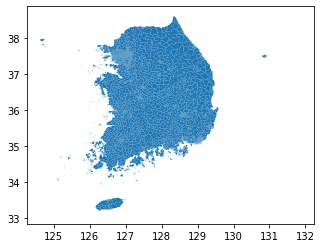

In [16]:
skorea_shape.plot()

In [17]:
type (filtered_seoul)

pandas.core.frame.DataFrame

In [9]:
#Dataset is currently a dataframe and needs to be a gdf so it can be joined with the shapefile.
#Custom function below provided by UC Berkeley's Urban Displacement Project)

def geometrize_tweets(df):
    """
    Convert DataFrame of tweets into GeoDataFrames based on lat/lon coords.
    Parameters
    ----------
    data : pd.DataFrame
    Must contain columns 'lat' and 'lon' containing lat/lon coordinates
    Returns
    -------
    pd.geodataframe.GeoDataFrame
    """
    # Create a shapely.geometry.Point for each tweet
    geometry = [Point(xy) for xy in zip(df['location.lon'], df['location.lat'])]
    crs = {'init':'epsg:4326'}
    # Convert to GeoDataFrame, where each tweet's geometry is assigned to the lat/lon coords
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

filtered_geometrized= geometrize_tweets(filtered_seoul)

#Checking the tweets' data type again
type (filtered_geometrized)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


geopandas.geodataframe.GeoDataFrame

In [22]:
#oh great. it worked. 
#spatially join the geometrized tweets w/ the south korea shape file
joined = gpd.sjoin(filtered_geometrized, skorea_shape, how='left', op='within')
print(joined.shape)
joined.head()

/opt/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


(19938, 20)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,name,base_year,name_eng,code
1110,227553058614284289,1.343088e+12,"며칠 전 퇴근길 선택의 자유에 대해 적었었는데, 출근길 선택의 자유 역시 대단히 매...",173419326,Wook-wan Ha 하욱완,1.280665e+12,"괜찮은 책 두어권, 내 오랜 스쿠터, 가다가 기름 넣고 편의점 캔커피 한 잔 할 정...",12,ll,KOR,limeraa,20,126.981713,37.574012,POINT (126.98171 37.57401),7.0,종로1·2·3·4가동,2018,Jongno1·2·3·4Gadong,1101061
1476,227418364207828992,1.343056e+12,이대에 가면 와인샤베트가 있다\n배부른 이대 저녁 거리를 \n깔끔하게 쏘다니기에 딱...,614442081,박은영,1.340289e+12,NaN,5,ll,KOR,peh337peh,6,126.854427,37.479367,POINT (126.85443 37.47937),1344.0,광명4동,2018,Gwangmyeong 4(sa)-dong,3106054
2270,227605153837096960,1.343100e+12,여기도 맛집! (@ 두레국수) http://t.co/j42lyBJS,221033694,스투시,1.291044e+12,*Poreka MarketingTeam PostVisual(SocialCommuni...,2793,ll,KOR,stussygo,950,127.043160,37.504690,POINT (127.04316 37.50469),364.0,역삼1동,2018,Yeoksam 1(il)-dong,1123064
3593,226258614409646080,1.342779e+12,칵테일이 땡겨서 미도리나 블루퀴라소를 사려고 봤더니 파는데가 안보인다. (오픈마켓에...,188203473,장미의신부,1.283920e+12,벌컥벌컥~!!,71,ll,KOR,ksj450,33,127.015599,37.573805,POINT (127.01560 37.57381),10.0,창신1동,2018,Changsin 1(il)-dong,1101067
4333,226700654217928704,1.342885e+12,그야말로 칼로리폭탄. 주문은 뷘마마께서 하셨는데 왜 제가 절반이상 마셔야하는지? (...,132813940,SHIN희도,1.271230e+12,In pursuit of happyness // \r\nFuture(s)+Optio...,2425,ll,KOR,GlisterWay,1499,126.951893,37.548014,POINT (126.95189 37.54801),221.0,아현동,2018,Ahyeon-dong,1114078


In [ ]:
## 3 neighborhood of interest (each is made up of multiple submunicipalities)

#'Yeonnam-dong' 
#'Seogyo-dong'

#"Itaewon 1(il)-dong"
#"Itaewon 2(i)-dong"

#"Seongsu1(il)-ga2(i)-dong"
#"Seongsu 2(i)-ga 3(sam)-dong"
#'Seongsu 2(i)-ga1(il)-dong'
#"Seongsu1(il)-ga1(il)-dong"


In [74]:
#Ended up identifying neighborhoods by their "code" because English spellings varied from different data sets

neighborhood_1=joined['name_eng']=='Yeonnam-dong' 
neighborhood_2=joined['name_eng'].str.contains('Itaewon')
neighborhood_3=joined['name_eng'].str.contains('Seongsu')
neighborhood_4=joined['name_eng']=='Seogyo-dong'

all_filters= neighborhood_1|neighborhood_2|neighborhood_3|neighborhood_4
selected_tweets_places.shape

#1719 tweets using key words in the neighborhoods on interest

(1719, 20)

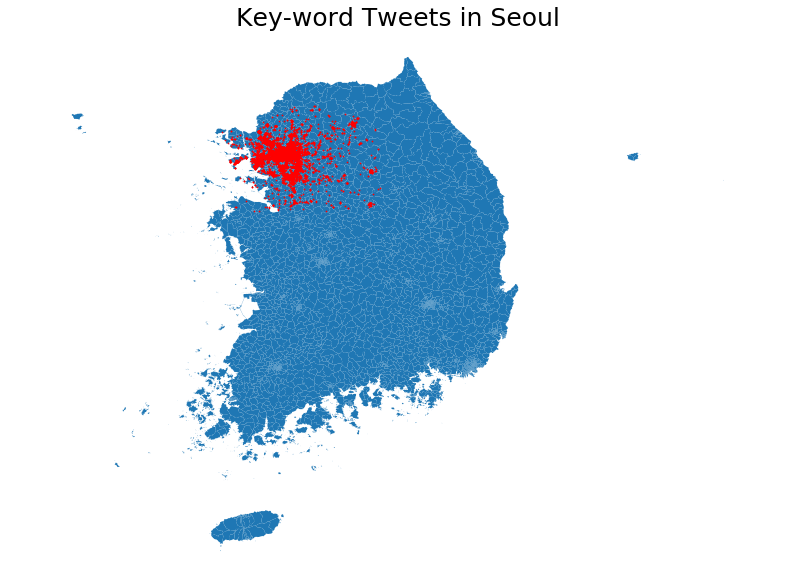

In [62]:
#Plotting the selected tweets

fig, ax = plt.subplots(figsize=(14, 10))
base=skorea_shape.plot(ax=ax)
joined.plot(ax=base, markersize=.5, color='red')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Key-word Tweets in Seoul', fontdict= 
            {'fontsize':25})

plt.show()

#Showing all keyword tweets, not limited by neighborhood. Each red dot represents a tweet. 

In [63]:
#Zooming into the map by making the base map Seoul
seoul_shape= gpd.read_file(r'seoul_neighborhoods.shx')
seoul_shape.head()

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515..."
1,11110118,내수동,Naesu-dong,59,0.000007,0.011823,"POLYGON ((126.97318 37.57399, 126.97328 37.573..."
2,11590105,흑석동,Heukseok-dong,15,0.000171,0.057420,"POLYGON ((126.96639 37.51014, 126.96687 37.509..."
3,11320107,창동,Chang-dong,1,0.000436,0.100323,"POLYGON ((127.05147 37.66043, 127.05150 37.659..."
4,11230107,청량리동,Cheongnyangni-dong,8,0.000122,0.064774,"POLYGON ((127.04305 37.59696, 127.04361 37.596..."


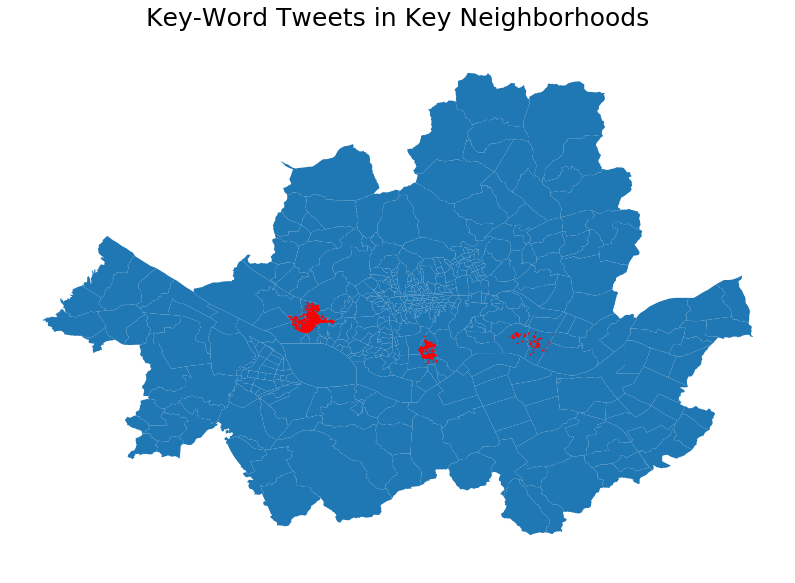

In [75]:
#Plotting the selected tweets in the neighborhoods of interest

fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
selected_tweets_places.plot(ax=base, markersize=.5, color='red')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Key-Word Tweets in Key Neighborhoods', fontdict= 
            {'fontsize':25})

plt.show()

In [23]:
#Separating filtered tweets (key word, all neighborhoods) by date to understand any trends over time

In [76]:
#Adding the date and time to the tweets w/ key words

joined['timestamp'] = pd.to_datetime(joined['created_at'] // 1000, unit='s')
joined['date'] = joined['timestamp'].dt.date
joined['date'] = pd.to_datetime(joined.date)

In [67]:
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 19934 entries, 1110 to 12038456
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 19934 non-null  int64         
 1   created_at         19934 non-null  float64       
 2   text               19934 non-null  object        
 3   u_id               19934 non-null  int64         
 4   u_name             19934 non-null  object        
 5   u_created_at       19934 non-null  float64       
 6   u_description      17516 non-null  object        
 7   u_followers_count  19934 non-null  int64         
 8   type               19934 non-null  object        
 9   c_country          19934 non-null  object        
 10  u_screen_name      19934 non-null  object        
 11  u_friends_count    19934 non-null  int64         
 12  location.lon       19934 non-null  float64       
 13  location.lat       19934 non-null  float64     

In [77]:
#Function to filter by year

def filter_by_date(df,start_date,end_date):
    """
    Filter df based on date
    
    date format= 'xxxx-x-x'
    """

    after_start_date = df["date"] >= start_date
    before_end_date = df["date"] <= end_date
    between_two_dates = after_start_date & before_end_date
    
    return df.loc[between_two_dates]

In [78]:
joined_2012= filter_by_date(joined,'2012-1-1','2012-12-31')
joined_2013= filter_by_date(joined,'2013-1-1','2013-12-31')
joined_2014= filter_by_date(joined,'2014-1-1','2014-12-31')
joined_2015= filter_by_date(joined,'2015-1-1','2015-12-31')
joined_2016= filter_by_date(joined,'2016-1-1','2016-12-31')

In [79]:
# Number of tweets in each year
print (joined_2012.shape)
print (joined_2013.shape)
print (joined_2014.shape)
print (joined_2015.shape)
print (joined_2016.shape)

(2305, 22)
(3746, 22)
(3784, 22)
(4507, 22)
(5592, 22)


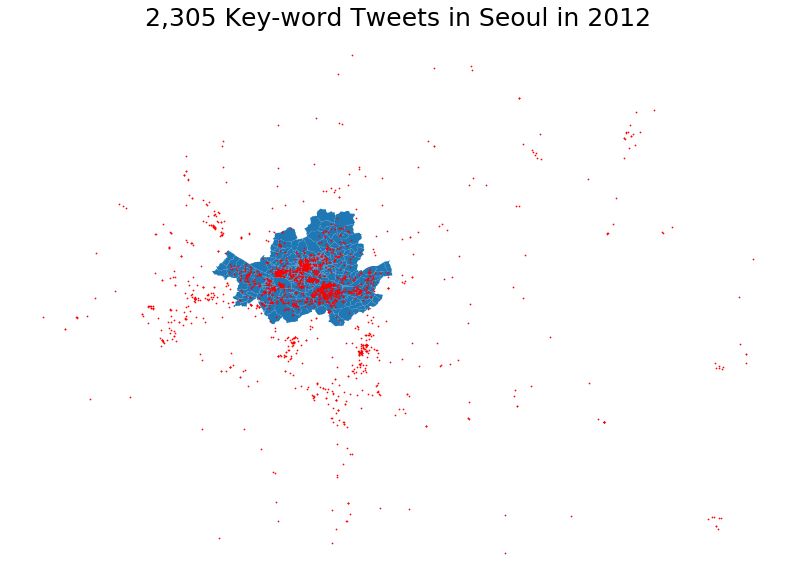

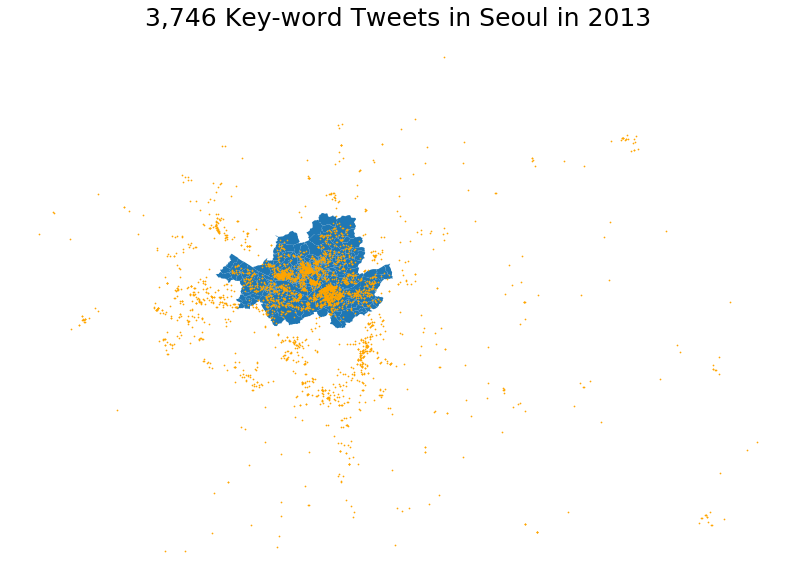

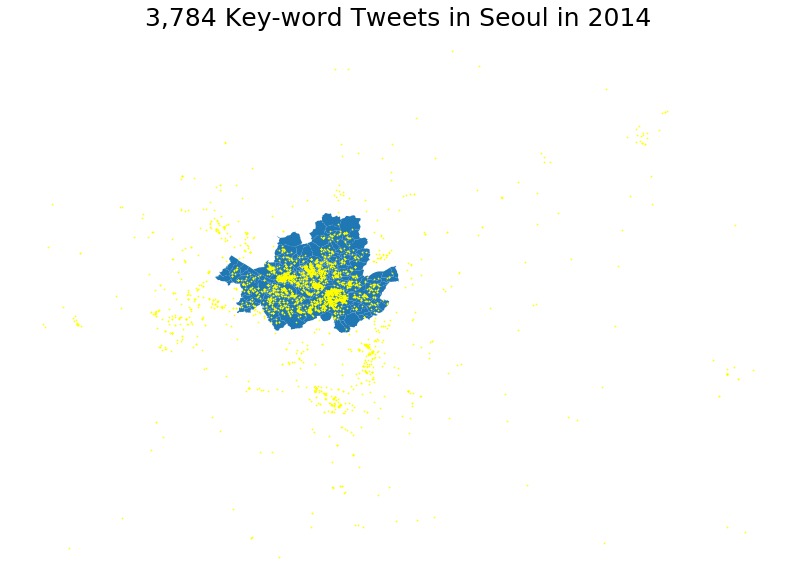

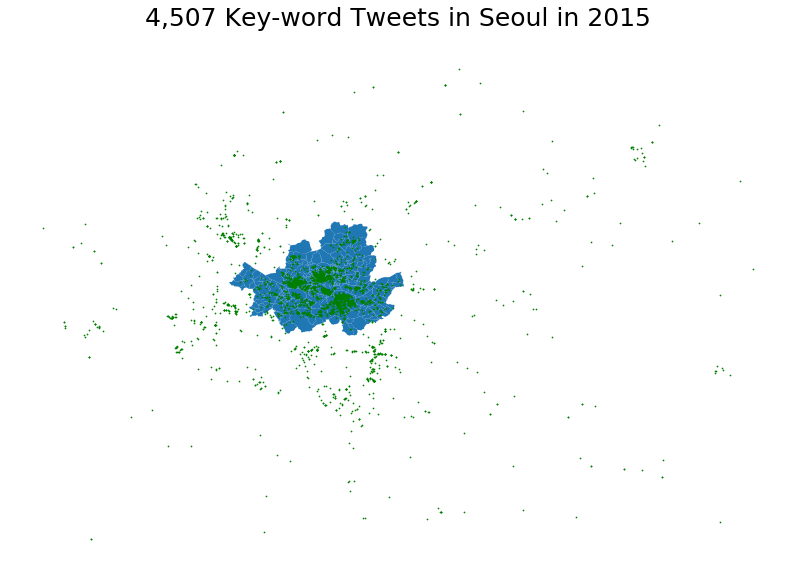

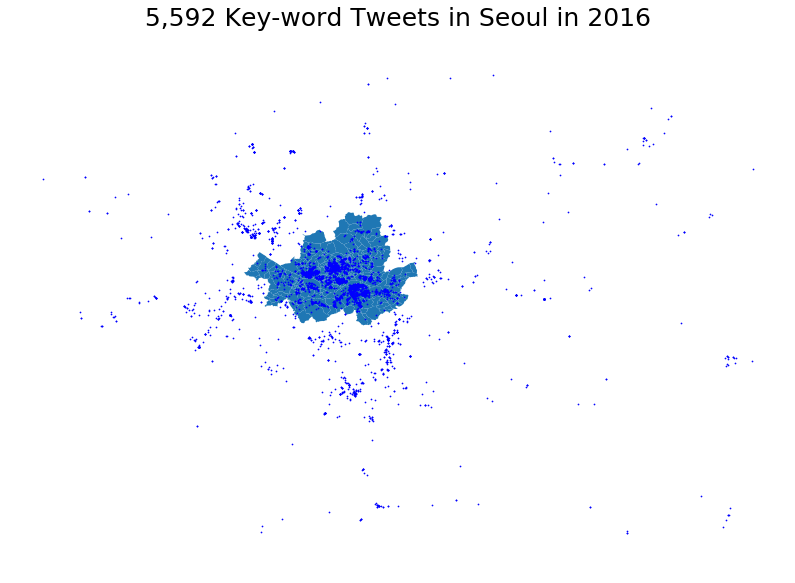

In [80]:
#Comparing tweets across time
#2012
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
joined_2012.plot(ax=base, markersize=.5, color='red')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('2,305 Key-word Tweets in Seoul in 2012', fontdict= 
            {'fontsize':25})
plt.show()

#2013
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
joined_2013.plot(ax=base, markersize=.5, color='orange')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('3,746 Key-word Tweets in Seoul in 2013', fontdict= 
            {'fontsize':25})
plt.show()

#2014
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
joined_2014.plot(ax=base, markersize=.5, color='yellow')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('3,784 Key-word Tweets in Seoul in 2014', fontdict= 
            {'fontsize':25})
plt.show()

#2015
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
joined_2015.plot(ax=base, markersize=.5, color='green')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('4,507 Key-word Tweets in Seoul in 2015', fontdict= 
            {'fontsize':25})
plt.show()

#2016
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
joined_2016.plot(ax=base, markersize=.5, color='blue')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('5,592 Key-word Tweets in Seoul in 2016', fontdict= 
            {'fontsize':25})
plt.show()

In [81]:
#Comparing key-word tweets in key neighborhoods over time

#Filtering each year's dataset by neighborhood
def neighborhood_filter(df, neighborhood_column):
    n_1=df[neighborhood_column]=='Yeonnam-dong'
    n_2=df[neighborhood_column].str.contains('Itaewon')
    n_3=df[neighborhood_column].str.contains('Seongsu')
    n_4=df[neighborhood_column]=='Seogyo-dong'

    all_neighborhoods= n_1|n_2|n_3|n_4
    return df[all_neighborhoods]

selected_tweets_places_2012= neighborhood_filter(joined_2012,'name_eng')
selected_tweets_places_2013= neighborhood_filter(joined_2013,'name_eng')
selected_tweets_places_2014= neighborhood_filter(joined_2014,'name_eng')
selected_tweets_places_2015= neighborhood_filter(joined_2015,'name_eng')
selected_tweets_places_2016= neighborhood_filter(joined_2016,'name_eng')

#see how many tweets are in each
print (selected_tweets_places_2012.shape)
print (selected_tweets_places_2013.shape)
print (selected_tweets_places_2014.shape)
print (selected_tweets_places_2015.shape)
print (selected_tweets_places_2016.shape)

(124, 22)
(212, 22)
(327, 22)
(536, 22)
(520, 22)


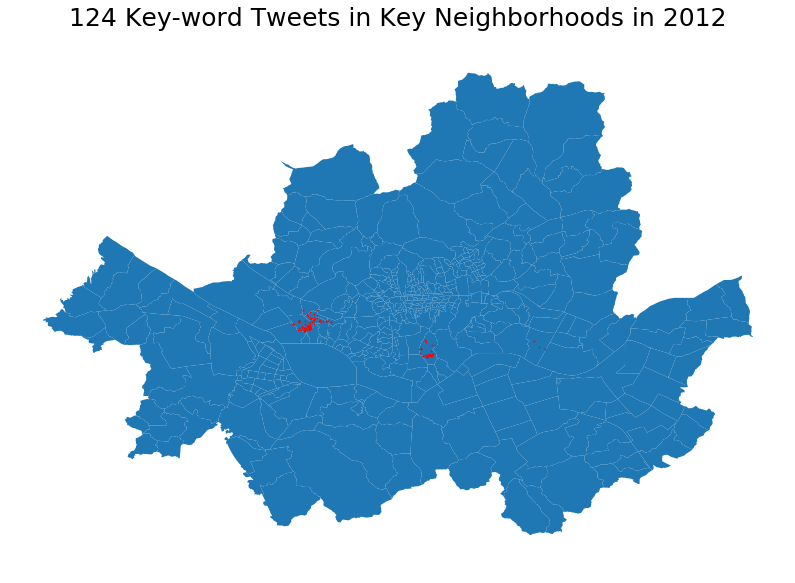

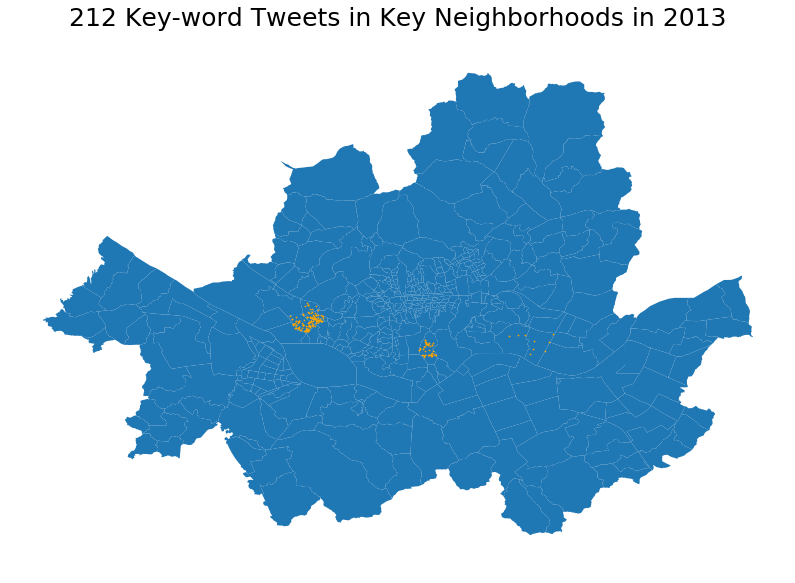

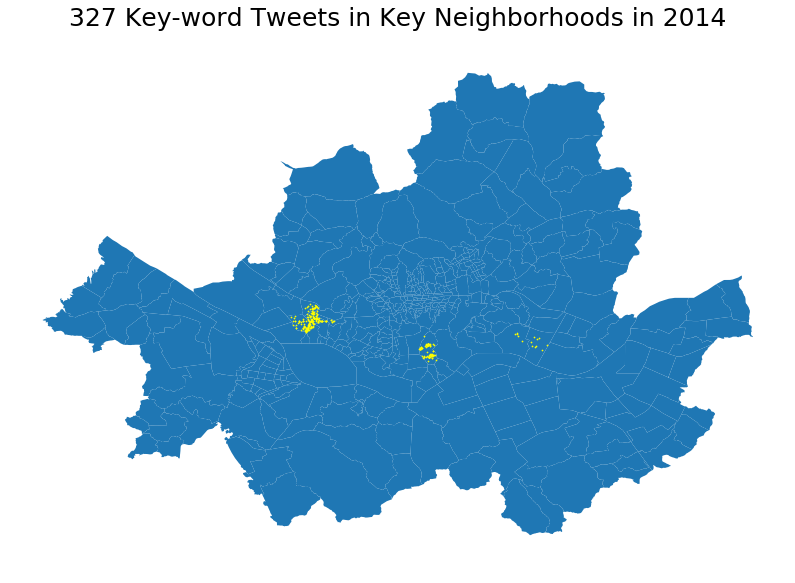

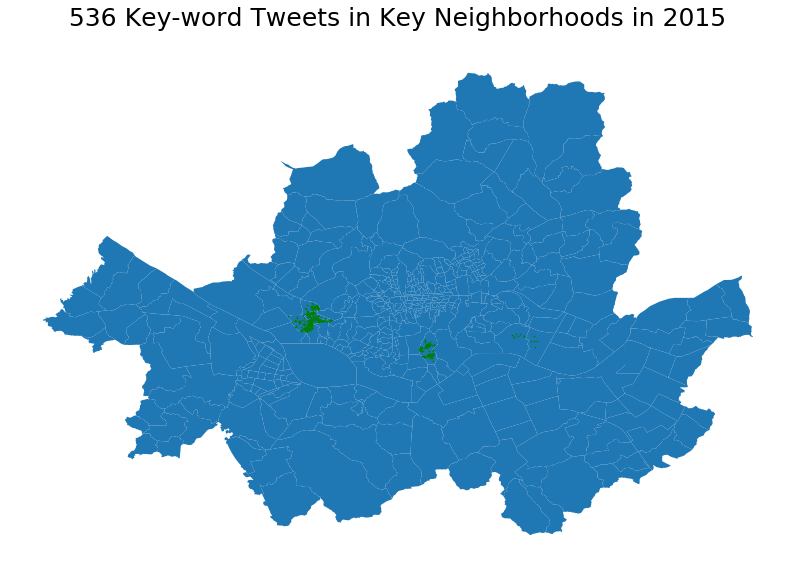

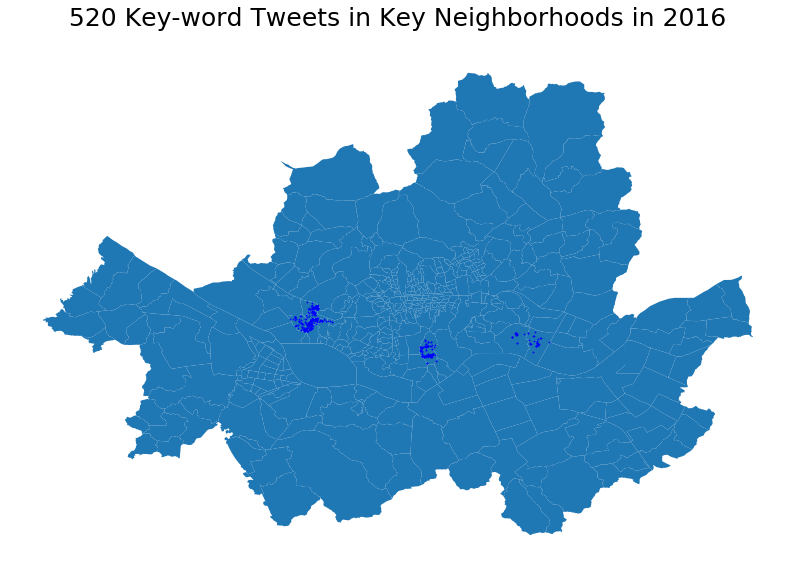

In [73]:
#Mapping the tweets over time

#2012
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
selected_tweets_places_2012.plot(ax=base, markersize=.5, color='red')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('124 Key-word Tweets in Key Neighborhoods in 2012', fontdict= 
            {'fontsize':25})
plt.show()

#2013
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
selected_tweets_places_2013.plot(ax=base, markersize=.5, color='orange')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('212 Key-word Tweets in Key Neighborhoods in 2013', fontdict= 
            {'fontsize':25})
plt.show()

#2014
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
selected_tweets_places_2014.plot(ax=base, markersize=.5, color='yellow')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('327 Key-word Tweets in Key Neighborhoods in 2014', fontdict= 
            {'fontsize':25})
plt.show()

#2015
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
selected_tweets_places_2015.plot(ax=base, markersize=.5, color='green')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('536 Key-word Tweets in Key Neighborhoods in 2015', fontdict= 
            {'fontsize':25})
plt.show()

#2016
fig, ax = plt.subplots(figsize=(14, 10))
base=seoul_shape.plot(ax=ax)
selected_tweets_places_2016.plot(ax=base, markersize=.5, color='blue')
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('520 Key-word Tweets in Key Neighborhoods in 2016', fontdict= 
            {'fontsize':25})
plt.show()

In [116]:
#Making a table of number of key-word tweets in each neighborhood over time
pd.DataFrame({'neighorhood': ['Yeonnam-dong','Itaewon-dong','Seongsu-dong','Seogyo-dong','year totals'],
'2012': [3, 36, 3,82,124],
'2013': [11, 46, 9, 146,212],
'2014': [25, 92,14,196,327],
'2015': [83, 143, 13, 297,536], 
'2016': [85, 120, 57, 258,520],
'neighborhood totals': [207, 437, 96, 979,1719]})

,neighorhood,2012,2013,2014,2015,2016,neighborhood totals
0,Yeonnam-dong,3,11,25,83,85,207
1,Itaewon-dong,36,46,92,143,120,437
2,Seongsu-dong,3,9,14,13,57,96
3,Seogyo-dong,82,146,196,297,258,979
4,year totals,124,212,327,536,520,1719


In [112]:
#Double checking tweet counts in the Seongsu neighborhood
print(joined[joined['name_eng']=="Seongsu1(il)-ga2(i)-dong"].shape)
print(joined[joined['name_eng']=="Seongsu 2(i)-ga 3(sam)-dong"].shape)
print(joined[joined['name_eng']=='Seongsu 2(i)-ga1(il)-dong'].shape)
print(joined[joined['name_eng']=="Seongsu1(il)-ga1(il)-dong"].shape)

#Confirming that there are 96 tweets total in Seongsu across all 5 years. 

(27, 22)
(20, 22)
(36, 22)
(13, 22)
